In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

rawdata = pd.read_csv('./data/mobike_shanghai_sample_updated.csv')
rawdata.head()


,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track
0,78387,158357,10080,2016-08-20 06:57,121.348,31.389,2016-08-20 07:04,121.357,31.388,"121.347,31.392#121.348,31.389#121.349,31.390#1..."
1,891333,92776,6605,2016-08-29 19:09,121.508,31.279,2016-08-29 19:31,121.489,31.271,"121.489,31.270#121.489,31.271#121.490,31.270#1..."
2,1106623,152045,8876,2016-08-13 16:17,121.383,31.254,2016-08-13 16:36,121.405,31.248,"121.381,31.251#121.382,31.251#121.382,31.252#1..."
3,1389484,196259,10648,2016-08-23 21:34,121.484,31.320,2016-08-23 21:43,121.471,31.325,"121.471,31.325#121.472,31.325#121.473,31.324#1..."
4,188537,78208,11735,2016-08-16 07:32,121.407,31.292,2016-08-16 07:41,121.418,31.288,"121.407,31.291#121.407,31.292#121.408,31.291#1..."


In [3]:
rawdata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102361 entries, 0 to 102360
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   orderid           102361 non-null  int64  
 1   bikeid            102361 non-null  int64  
 2   userid            102361 non-null  int64  
 3   start_time        102361 non-null  object 
 4   start_location_x  102361 non-null  float64
 5   start_location_y  102361 non-null  float64
 6   end_time          102361 non-null  object 
 7   end_location_x    102361 non-null  float64
 8   end_location_y    102361 non-null  float64
 9   track             102361 non-null  object 
dtypes: float64(4), int64(3), object(3)
memory usage: 7.8+ MB


In [4]:
# 复制数据集，并更改各列的数据类型
mobike = rawdata.copy()
tobestr = ['orderid', 'bikeid', 'userid']
mobike[tobestr] = mobike[tobestr].astype('str')
mobike['start_time'] = pd.to_datetime(mobike['start_time'])
mobike['end_time'] = pd.to_datetime(mobike['end_time'])
mobike.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102361 entries, 0 to 102360
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   orderid           102361 non-null  object        
 1   bikeid            102361 non-null  object        
 2   userid            102361 non-null  object        
 3   start_time        102361 non-null  datetime64[ns]
 4   start_location_x  102361 non-null  float64       
 5   start_location_y  102361 non-null  float64       
 6   end_time          102361 non-null  datetime64[ns]
 7   end_location_x    102361 non-null  float64       
 8   end_location_y    102361 non-null  float64       
 9   track             102361 non-null  object        
dtypes: datetime64[ns](2), float64(4), object(4)
memory usage: 7.8+ MB


**新增骑行时长duration等列（通过起始时间计算），并通过字符串拆分将骑行时长单位统一为minutes（命名为ttl_min列）**

In [5]:
mobike['duration'] = mobike.end_time - mobike.start_time
mobike['dur_day'] = mobike.duration.apply(lambda x: str(x).split(' ')[0])
mobike['dur_hr'] = mobike.duration.apply(lambda x: str(x).split(' ')[-1][:2])
mobike['dur_min'] = mobike.duration.apply(lambda x: str(x).split(':')[-2])
mobike['dur_sec'] = mobike.duration.apply(lambda x: str(x).split(':')[-1])
tobeint = ['dur_day', 'dur_hr', 'dur_min', 'dur_sec']
mobike[tobeint] = mobike[tobeint].astype('int')
mobike['ttl_min'] = mobike.dur_day * 24 * 60 + mobike.dur_hr * 60 + mobike.dur_min + mobike.dur_sec / 60


**新增dayid和daytype列，获取每条记录是星期几，并根据工作日和周末进行分类**

In [6]:
mobike['dayid'] = mobike.start_time.apply(lambda x: x.isoweekday())
mobike['daytype'] = mobike.dayid.apply(lambda x: 'weekends' if x == 6 or x == 7 else 'weekdays')


**新增hourid和hourtype列，获取每条记录是几点开始的，并根据早晚高峰和平峰时段进行分类**

In [7]:
mobike['hourid'] = mobike.start_time.apply(lambda x: x.utctimetuple().tm_hour)
mobike['hourtype'] = mobike.hourid.apply(lambda x: 'rush hours' if (x >= 7 and x <= 8) or (x >= 17 and x <= 20) else 'non-rush hours')


**新增地理位置信息相关的列**

新增distance和distocenter列，获取每条记录骑行起始点的直线距离和距离上海中心点的距离（km）

In [9]:
# 按每条记录的起点位置，作为发起订单所处位置的数据依据
from math import radians, cos, sin, asin, sqrt

# 自定义函数，通过两点的经纬度计算两点之间的直线距离
def geodistance(lng1, lat1, lng2, lat2):
    lng1_r, lat1_r, lng2_r, lat2_r = map(radians, [lng1, lat1, lng2, lat2]) # 经纬度转换成弧度
    dlon = lng1_r - lng2_r
    dlat = lat1_r - lat2_r
    dis = sin(dlat/2)**2 + cos(lat1_r) * cos(lat2_r) * sin(dlon/2)**2
    distance = 2 * asin(sqrt(dis)) * 6371 * 1000 # 地球平均半径为6371km
    distance = round(distance/1000,3)
    return distance

# 自定义函数，通过调用geodistance获取每条记录骑行始末点和起点距中心点的直线距离
def get_dis(item):
    item['distance'] = geodistance(item['start_location_x'], item['start_location_y'],
                                   item['end_location_x'], item['end_location_y'])    # 计算骑行始末点经纬度的直线距离
    # 国际饭店一般被认为是上海地理中心坐标点，计算骑行起始点经纬度和国际饭店经纬度的直线距离
    item['distocenter'] = geodistance(item['start_location_x'], item['start_location_y'], 121.471632, 31.233705)
    return item

mobike['distance'] = np.nan
mobike['distocenter'] = np.nan
mobike = mobike.apply(get_dis, axis=1)


**新增ring_stage列，对四级环线范围进行分类**

In [10]:
# 自定义函数，按照每条记录距离上海中心点（国际饭店）的距离，根据上海内中外环线进行粗略的地理位置分类
def get_ring(item):
    if item['distocenter'] <= 10:
        item['ring_stage'] = 'inside inner ring'    # 内环距国际饭店最远距离约为10km
    elif item['distocenter'] <= 15:
        item['ring_stage'] = 'inside middle ring'    # 中环距国际饭店最远距离约为15km
    elif item['distocenter'] <= 18:
        item['ring_stage'] = 'inside outer ring'    # 外环距国际饭店最远距离约为18km
    elif item['distocenter'] > 18:
        item['ring_stage'] = 'outside outer ring'
    return item

mobike['ring_stage'] = np.nan
mobike = mobike.apply(get_ring, axis = 1)


**用户RFM模型分级**

新增cost列，以用于后续计算

In [11]:
import math
mobike['cost'] = mobike.ttl_min.apply(lambda x: math.ceil(x/30))    # 参照2016年摩拜收费标准，按每30分钟收取1元进行cost列的粗略计算


**计算RFM值**

In [12]:
# 建立副本，将用户id以数字大小进行排序，以便后续rfm值计算时每条记录的顺序保持一致
mobike_sub = mobike.copy()
mobike_sub.userid = mobike_sub.userid.astype('int')
mobike_sub = mobike_sub.sort_values('userid')

# 计算RFM值，并制作新的dataframe
mobike_sub['r_value_single'] = mobike_sub.start_time.apply(lambda x: 32 - x.timetuple().tm_mday)    # 因数据集仅包含八月份发起的订单数据，故以9/1为R值计算基准
r_value = mobike_sub.groupby(['userid']).r_value_single.min()    # 按每个用户id所有订单日期距9/1相差天数的最小值作为r值
f_value = mobike_sub.groupby(['userid']).size()    # 按每个用户id八月累积订单数量计算f值
m_value = mobike_sub.groupby(['userid']).cost.sum()    # 按每个用户id八月累积消费金额作为m值
rfm = pd.DataFrame({'r_value': r_value, 'f_value': f_value, 'm_value': m_value})    # 将三个series合并为新的dataframe

# 查看rfm数据概要
rfm.describe()


,r_value,f_value,m_value
count,16887.000000,16887.000000,16887.000000
mean,5.132054,6.061527,7.081660
std,5.269800,3.480024,4.865784
min,1.000000,1.000000,1.000000
25%,1.000000,3.000000,4.000000
50%,3.000000,6.000000,6.000000
75%,7.000000,8.000000,10.000000
max,31.000000,25.000000,170.000000


按数据分布情况，建立评分标准表格

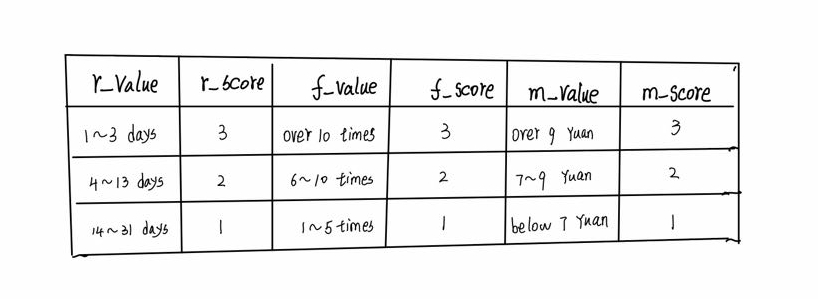

**进行RFM评分**

In [13]:
# 自定义函数，分别根据rfm值，对每个用户id进行打分
def get_rfm(item):
    # 为r_value评级
    if item.r_value < 4:
        item['r_score'] = 3
    if item.r_value <= 13 and item.r_value >= 4:
        item['r_score'] = 2
    if item.r_value > 13:
        item['r_score'] = 1
    # 为f_value评级
    if item.f_value > 10:
        item['f_score'] = 3
    if item.f_value <= 10 and item.f_value >= 6:
        item['f_score'] = 2
    if item.f_value < 6:
        item['f_score'] = 1
    # 为m_value评级
    if item.m_value > 9:
        item['m_score'] = 3
    if item.m_value <= 9 and item.m_value >= 7:
        item['m_score'] = 2
    if item.m_value < 7:
        item['m_score'] = 1
    return item

rfm['r_score'] = np.nan
rfm['f_score'] = np.nan
rfm['m_score'] = np.nan
rfm = rfm.apply(get_rfm, axis = 1)

# 查看rfm评分数据分布情况是否合理
print(rfm.r_score.value_counts())
print(rfm.f_score.value_counts())
print(rfm.m_score.value_counts())


3.0    8890
2.0    6594
1.0    1403
Name: r_score, dtype: int64
1.0    8220
2.0    6752
3.0    1915
Name: f_score, dtype: int64
1.0    8633
3.0    4226
2.0    4028
Name: m_score, dtype: int64


计算每个用户RFM总分，并进行用户分层

In [14]:
rfm['score'] = rfm.r_score + rfm.f_score + rfm.m_score    # 每个用户rfm分数加总
rfm.score.value_counts()    # 查看用户得分数据分布情况是否合理


5.0    4038
4.0    3407
7.0    2877
6.0    2133
8.0    1940
9.0    1391
3.0    1101
Name: score, dtype: int64

In [15]:
# 自定义函数，分三段进行用户分层
def get_rate(item):
    if item.score >= 7:
        item.rate = 'high-value user'
    elif item.score >= 5:
        item.rate = 'middle-value user'
    else:
        item.rate = 'low-value user'
    return item
rfm['rate'] = np.nan
rfm = rfm.apply(get_rate, axis = 1)
rfm.rate.value_counts()    # 查看用户分层级别分布情况是否合理


high-value user      6208
middle-value user    6171
low-value user       4508
Name: rate, dtype: int64

合并dataframe

In [16]:
mobike.userid = mobike.userid.astype('int')    # 先将mobike中的userid列转换为int类型，实现与rfm中int型index的匹配，以便于操作merge函数
mobike = mobike.merge(rfm, on = 'userid', how = 'inner')

mobike.info()    # 查看数据类型，以用于后续整理


<class 'pandas.core.frame.DataFrame'>
Int64Index: 102361 entries, 0 to 102360
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   orderid           102361 non-null  object         
 1   bikeid            102361 non-null  object         
 2   userid            102361 non-null  int64          
 3   start_time        102361 non-null  datetime64[ns] 
 4   start_location_x  102361 non-null  float64        
 5   start_location_y  102361 non-null  float64        
 6   end_time          102361 non-null  datetime64[ns] 
 7   end_location_x    102361 non-null  float64        
 8   end_location_y    102361 non-null  float64        
 9   track             102361 non-null  object         
 10  duration          102361 non-null  timedelta64[ns]
 11  dur_day           102361 non-null  int64          
 12  dur_hr            102361 non-null  int64          
 13  dur_min           102361 non-null  int64    

In [17]:
# 将对应列转换成字符串变量
mobike.userid = mobike.userid.astype('str')
# 将对应列转换成整型变量
tobeint = ['ttl_min', 'r_value', 'f_value', 'm_value', 'r_score', 'f_score', 'm_score', 'score']
mobike[tobeint] = mobike[tobeint].astype('int')
# 将对应列转换成类别变量
order_dict = {'ring_stage': ['inside inner ring', 'inside middle ring', 'inside outer ring', 'outside outer ring'],
              'rate': ['high-value user', 'middle-value user', 'low-value user'],
              'daytype': ['weekdays', 'weekends'],
              'hourtype': ['rush hours', 'non-rush hours']}
for var in order_dict:
    order = pd.api.types.CategoricalDtype(ordered = True, categories = order_dict[var])
    mobike[var] = mobike[var].astype(order)


**数据集的结构**

数据集由32个变量组成，具有3275552个观测值，主要数据字典如下：

- start_time：订单发起时间 start_location_x：骑行起点经度
- start_location_y：骑行起点纬度
- end_time：订单结束时间 end_location_x：骑行终点经度
- end_location_y：骑行终点纬度
- duration：骑行时长，按订单发起和结束时间间隔计算，单位按天/时/分/秒表示
- ttl_min：骑行时长，通过duration数据进行单位统一，因原始数据中的时间精度仅到分，故该变量单位精确到分
- dayid：星期编号（按订单发起时间统计）
- daytype：工作日/双休日（按订单发起时间统计）
- hourid：小时编号（按订单发起时间统计）
- hourtype：高峰时段/非高峰时段（按订单发起时间统计）
- distance：骑行始末点的直线距离（km）
- distocenter：骑行起点距离上海市中心点的直线距离（km）
- ring_stage：以上海内环、中环、外环为界，分为四级地理位置
- cost：按照每笔订单的骑行时长，粗略估计的订单金额（元）
- score：用户价值评分
- rate：用户价值等级

数据集共有4个类型变量、21个数值变量、4个字符串变量、2个时间变量和1个时间差变量，其中4个类型变量具体如下：

- daytype：周一至周五为工作日，周六及周日为双休日
- hourtype：早7-8点及晚17-20点为高峰时段，其他时段为非高峰时段
- ring_stage：inside inner ring、inside middle ring、inside outer ring、outside outer ring分别代表内环内、中环内、外环内、外环外
- rate：high-value user、middle-value user、low-value user分别代表高价值用户、中等价值用户、低价值用户

**数据集中的关键分析指标**

探索影响骑行时长（ttl_min）的特征因素（此处更重要的分析指标应为订单金额，但因原始数据中不包含该数据，现有cost数据为粗略估算而非真实数据，仅适合作为参考分析使用，故此处选取与订单金额高度相关的骑行时长（ttl_min）作为关键分析指标）

**数据集内可以帮助探索关键分析指标的其他数据**

推测骑行时长与骑行距离（distance）高度相关，订单时间相关的数据（daytype、hourtype等）与骑行时长相关性较高（如高峰时段骑行时长可能较短），其他如地理位置（ring_stage）、用户质量（rate）等数据可能也会影响骑行时长



**单变量探索分析**

首先查看关键分析指标骑行时长 （ttl_min）的数据分布情况

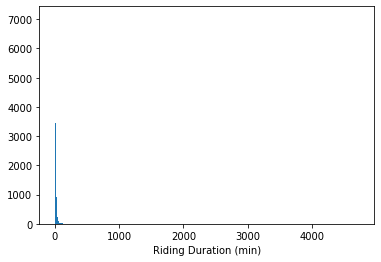

In [18]:
df_e = mobike.copy()
# 将对应列转换成类别变量
order_dict = {'ring_stage': ['inside inner ring', 'inside middle ring', 'inside outer ring', 'outside outer ring'],
              'rate': ['high-value user', 'middle-value user', 'low-value user'],
              'daytype': ['weekdays', 'weekends'],
              'hourtype': ['rush hours', 'non-rush hours']}
for var in order_dict:
    order = pd.api.types.CategoricalDtype(ordered = True, categories = order_dict[var])
    df_e[var] = df_e[var].astype(order)
    
bins = np.arange(0, df_e.ttl_min.max()+1, 1)
plt.hist(data = df_e, x = 'ttl_min', bins = bins);
plt.xlabel('Riding Duration (min)');


观察到x轴的数据范围异常大（连续骑行4000分钟以上显然是不正常的），判断数据集中存在异常数据，可能是用户骑行后忘关锁造成的。其他异常情况还包括使用汽车运载开锁后的摩拜单车等情况。

故此，下一步新增speed列，并大致剔除同时满足骑行速度明显异常（骑行速度一般在12-20km/h）、骑行时长或骑行距离明显异常的记录。然后再重新绘制直方图观察骑行时长的数据分布情况

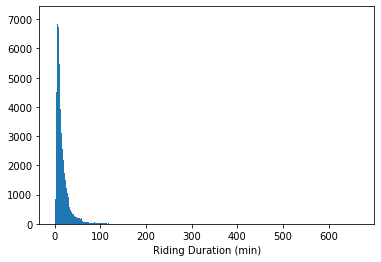

In [19]:
df_e['speed'] = df_e['distance'] / (df_e['ttl_min'] / 60)
df_e = df_e[-(((df_e['speed'] < 12) | (df_e['speed'] > 20)) & ((df_e['ttl_min'] > 720) | (df_e['distance'] > 50)))]
bins = np.arange(0, df_e.ttl_min.max()+1, 1)
plt.hist(data = df_e, x = 'ttl_min', bins = bins);
plt.xlabel('Riding Duration (min)');


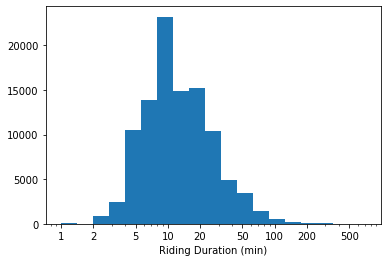

In [20]:
# 观察到数据分布存在明显的长尾，对x轴使用log变化以观察分布规律
bins = 10 ** np.arange(0, np.log10(df_e.ttl_min.max()) + 0.15, 0.15)
plt.hist(data = df_e, x = 'ttl_min', bins = bins);
plt.xscale('log')
xticks = (1, 2, 5, 10, 20, 50, 100, 200, 500)
plt.xticks(xticks, xticks);
plt.xlabel('Riding Duration (min)');


骑行时长数据呈现长尾分布，绝大多数骑行时长较短，极少数骑行时间较长。使用log转换x轴绘图可以发现，骑行时长呈现右偏态分布，峰值出现在7-10分钟之间

下一步查看distance的数据分布情况

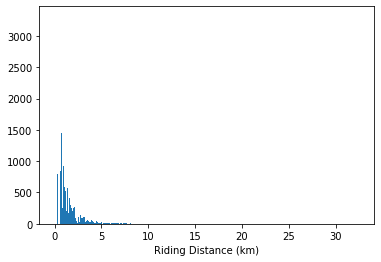

In [21]:
bins = np.arange(0, df_e.distance.max()+0.01, 0.01)
plt.hist(data = df_e, x = 'distance', bins = bins);
plt.xlabel('Riding Distance (km)');


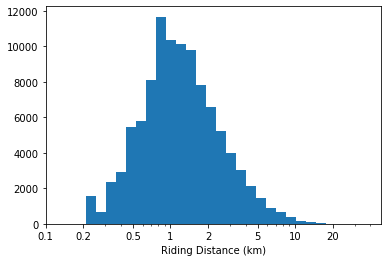

In [22]:
# 骑行距离同样存在长尾分布特征，对x轴使用log变化以观察分布规律
bins = 10 ** np.arange(np.log10(df_e.distance.min()), np.log10(df_e.distance.max()) + 0.08, 0.08)
plt.hist(data = df_e, x = 'distance', bins = bins);
plt.xscale('log')
xticks = (0.1, 0.2, 0.5, 1, 2, 5, 10, 20)
plt.xticks(xticks, xticks);
plt.xlabel('Riding Distance (km)');


骑行距离数据同样呈现长尾分布，绝大多数骑行距离较短，极少数骑行距离较长。使用log转换x轴绘图可以发现，骑行距离呈现右偏态分布，峰值出现在0.7-1.3公里之间

下一步查看daytype、hourtype、ring_stage、rate四个类别变量的分布情况

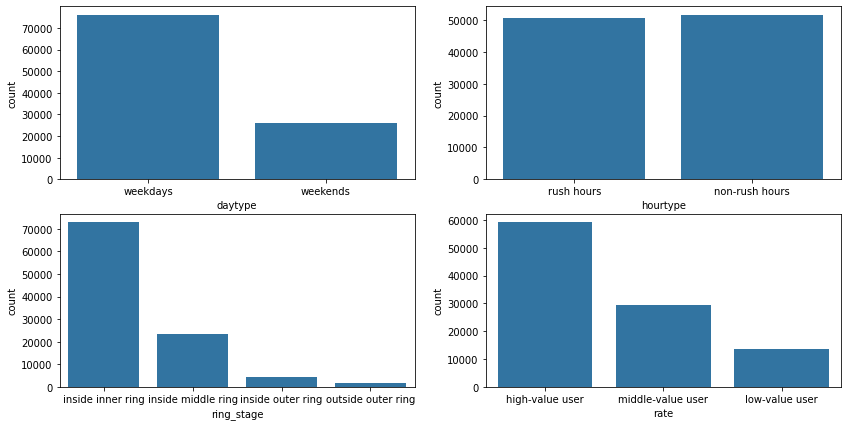

In [23]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = [14, 7])
color = sb.color_palette()[0]
sb.countplot(data = df_e, x = 'daytype', color = color, ax = ax[0, 0]);
sb.countplot(data = df_e, x = 'hourtype', color = color, ax = ax[0, 1]);
sb.countplot(data = df_e, x = 'ring_stage', color = color, ax = ax[1, 0]);
sb.countplot(data = df_e, x = 'rate', color = color, ax = ax[1, 1]);


观察到数据集中工作日的订单量约为双休日的三倍，考虑到工作日天数是双休日天数的2.5倍，可判断工作日平均订单量略高于双休日平均订单量；骑行时间约一半是在上下班高峰期间；绝大多数的骑行起点均位于内环内，且起点距离市中心越远，订单量下降幅度约明显；超过一半的骑行订单是由高价值用户发起的，用户价值越低，订单量越少

**变量的分布情况、异常点和数值转换使用情况**

骑行时长和骑行距离的数值范围都非常大，通过对数据的呈现方式进行log转化，骑行时长和骑行距离的数据分布均呈现右偏态分布，峰值分别在7-10分钟和0.7-1.3公里；四个类型变量的分布情况如下：①工作日订单量约为双休日订单量的三倍；②高峰时段订单量略微低于非高峰时段；③内环内订单量占总订单量半数以上，且随着骑行区域离上海市中心越远，订单量越少；④高价值用户的订单量超过总订单量的一半，且随着用户价值越低，订单量越少

***在数据探索中发现的异常分布情况，以及对此做出的清理、调整、格式转化等操作和原因**

在初次探索骑行时长和骑行距离的数据分布情况时，数值范围的最大值明显异常，通过剔除骑行速度、距离、时长的异常记录，提升数据集的数据质量，以便进一步操作

**双变量探索分析**

首先查看两个数值变量之间的相关性，但由于这两个变量的数值范围过大，均存在非常长的长尾，为更好地观察数据情况，故在后续操作中使用经过log转换的数据（新增log_ttl_min、log_distance两列）

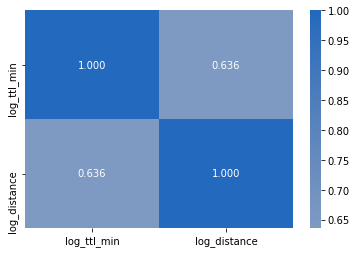

In [24]:
df_e['log_ttl_min'] = np.log10(df_e['ttl_min'])
df_e['log_distance'] = np.log10(df_e['distance'])
num_vars = ['log_ttl_min', 'log_distance']
cat_vars = ['daytype', 'hourtype', 'ring_stage', 'rate']
sb.heatmap(df_e[num_vars].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0);


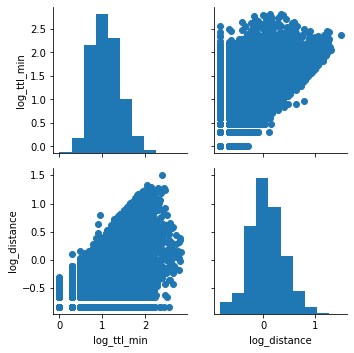

In [25]:
g = sb.PairGrid(data = df_e, vars = num_vars)
g = g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);


经过log转换后的骑行时长和骑行距离之间的相关系数为0.634，为显著相关

下一步，查看骑行时长和骑行距离两个数值变量和其他类别变量之间的关系

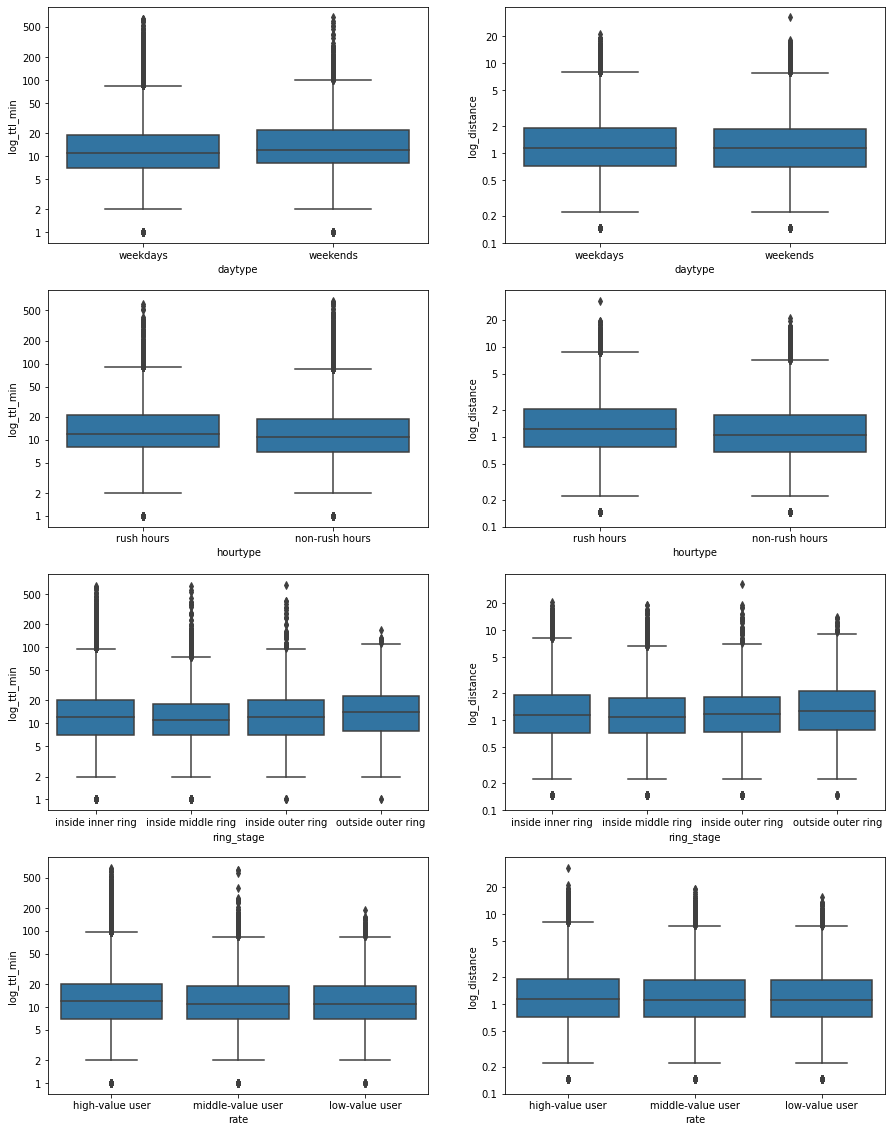

In [26]:
fig, ax = plt.subplots(ncols = 2, nrows = 4, figsize = [15,20])
for i in range(len(cat_vars)):
    var = cat_vars[i]
    # 画第一列的图
    sb.boxplot(data = df_e, x = var, y = 'log_ttl_min', ax = ax[i, 0], color = color);
    ttl_min_ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500]
    ax[i, 0].set_yticks(np.log10(ttl_min_ticks));
    ax[i, 0].set_yticklabels(ttl_min_ticks);
    # 画第二列的图
    sb.boxplot(data = df_e, x = var, y = 'log_distance', ax = ax[i, 1], color = color);
    distance_ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20]
    ax[i, 1].set_yticks(np.log10(distance_ticks));
    ax[i, 1].set_yticklabels(distance_ticks);



①在骑行时间方面，发现双休日和高峰时段的骑行时长和骑行距离的中位数相较工作日和非高峰时段都要更高（除双休日的骑行距离略微低于工作日）；②在骑行区域方面，一旦用户骑行区域在内环之外，骑行时长和骑行距离的中位数均随着离市中心越远而变得越高，可能是由于越靠近郊区，用户出发点和目的地之间的距离越来越大；③在用户价值方面，骑行时长和骑行距离的中位数均随着用户价值变低而变低。

下一步，由于骑行时长和骑行距离两个数值变量的数据特征和变化特征相似，可以进一步通过小提琴图看他们的具体数据分布情况如何（由于箱线图采用的是纵向排布，接下来的小提琴图可以采用横向排布方式，便于两个变量横轴方向的分布形状比较）

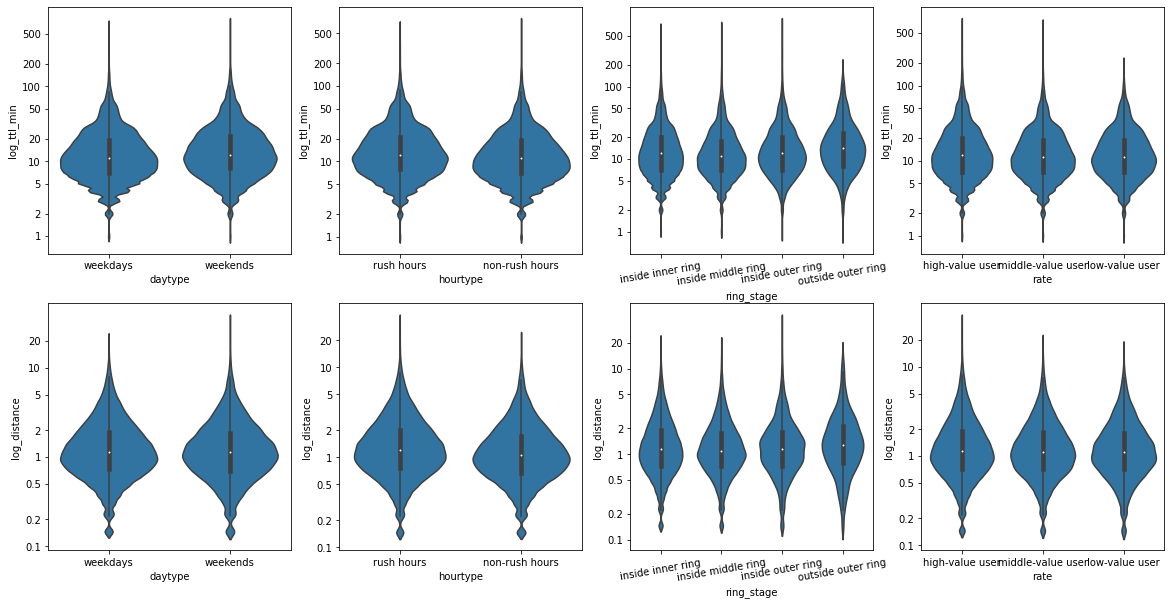

In [27]:
fig, ax = plt.subplots(ncols = 4, nrows = 2, figsize = [20,10])

for i in range(len(cat_vars)):
    var = cat_vars[i]
    # 画第一行的图
    sb.violinplot(data = df_e, x = var, y = 'log_ttl_min', ax = ax[0, i], color = color);
    ttl_min_ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500]
    ax[0, i].set_yticks(np.log10(ttl_min_ticks));
    ax[0, i].set_yticklabels(ttl_min_ticks);
    if i == 2:
        xlabels = ax[0, i].get_xticklabels()
        ax[0, i].set_xticklabels(xlabels, rotation = 10);
    # 画第二行的图
    sb.violinplot(data = df_e, x = var, y = 'log_distance', ax = ax[1, i], color = color);
    distance_ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20]
    ax[1, i].set_yticks(np.log10(distance_ticks));
    ax[1, i].set_yticklabels(distance_ticks);
    if i == 2:
        xlabels = ax[1, i].get_xticklabels()
        ax[1, i].set_xticklabels(xlabels, rotation = 10);


通过小提琴图和箱线图可以发现，骑行时长和骑行距离这两个数值变量的数据分布特征和分类情况下的变化特征几乎完全一样，后续可以不再对骑行距离做分析，原因如下：一方面骑行时长是原始数据中的真实数据（骑行距离是通过骑行始末点估算的直线距离），另一方面摩拜单车是根据骑行时长作为付费依据的，故此，在较高相关性和相似数据特征的情况下，选择数据质量和价值更高的骑行时长作为后续分析指标

最后看一下各个类型变量之间的关系

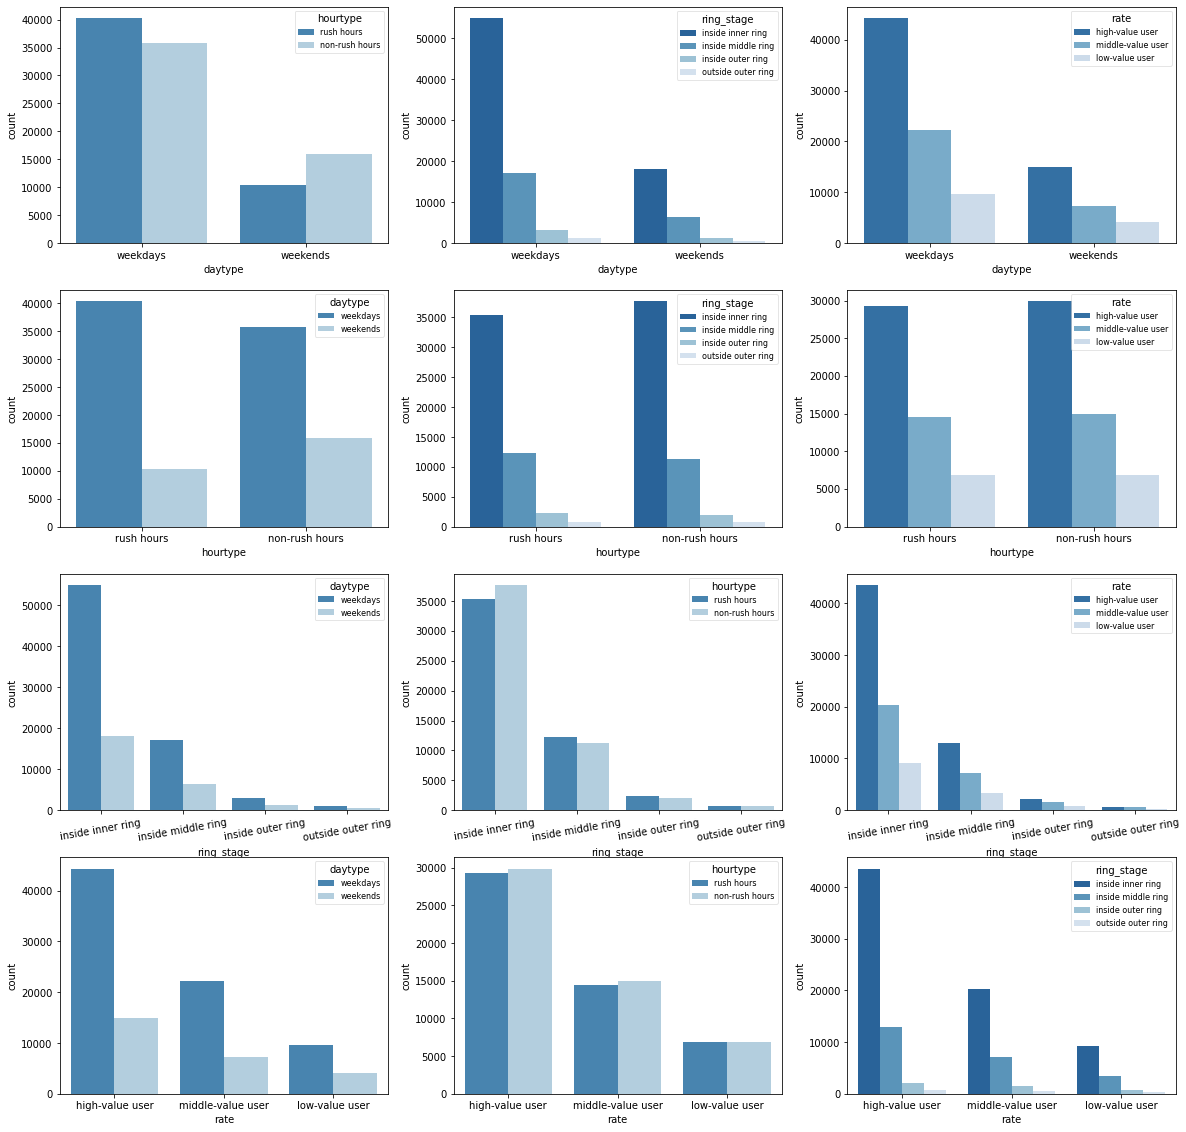

In [29]:
fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize = [20, 20])

for i in range(len(cat_vars)):
    count = 0
    for j in range(len(cat_vars)):
        if i == j:    # 跳过变量与其自身的绘图
            continue
        else:
            sb.countplot(data = df_e, x = cat_vars[i], hue = cat_vars[j], palette = 'Blues_r', ax = ax[i, count]);
            ax[i, count].legend(title = cat_vars[j], fontsize = 8, framealpha = 0.5);
            if i == 2:    # 第三个类别变量名称过长，设置一定的倾斜度以便阅读
                xlabels = ax[i, count].get_xticklabels()
                ax[i, count].set_xticklabels(xlabels, rotation = 10);
            count += 1


- 以工作日/双休日为观察视角：用户在工作日更多地在上下班高峰时段用车，在双休日更多在非高峰时段用车；工作日内环内的用车占比远高于双休日；不同价值用户在两种日子中的用车行为差异不大
- 以高峰时段/非高峰时段为观察视角：工作日的高峰时段用车比例明显高于双休日；不同环线范围的用户以及不用价值用户，在两种时段的用车行为差异不大
- 以不同环线范围为观察视角：用户在工作日用车次数占比高于双休日的程度，随着地理位置离市中心越远而变得越低，内环范围内明显强于其他地理范围，原因可能在于越靠近市中心、办公场所的分布越密集；不同环线范围在高峰时段/非高峰时段的用车行为差异不大，内环内非高峰时段用车数量略高于高峰时段，可能因为内环范围内活动场所相较其他范围更多，因此也会有更多非上班族的用车行为；内环内的高价值用户占比要远高于其他地区
- 以用户价值为观察视角：除高价值用户更多地分布在内环范围内，其他方面的用车行为差异不大

**关键分析指标和其他变量的相关性**

- 骑行时长在双休日和高峰时段相对更高
- 随着出发点距离市中心越远，骑行时长也越长
- 用户价值越高，骑行时长也越长
**除关键分析指标之外的其他变量之间的相关性**

- 工作日的高峰时段和双休日的非高峰时段用车量较大
- 工作日用车量占比高于双休日的程度，随着地理位置离市中心越远而变得越低，内环范围内明显强于其他地理范围
- 高价值用户更多地分布在内环范围内

**多变量探索分析**

主要探索四个类别变量是如何影响骑行时长的

<ipython-input-30-99427187ce23>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(var)
<ipython-input-30-99427187ce23>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(var)
<ipython-input-30-99427187ce23>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(var)
<ipython-input-30-99427187ce23>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(var)


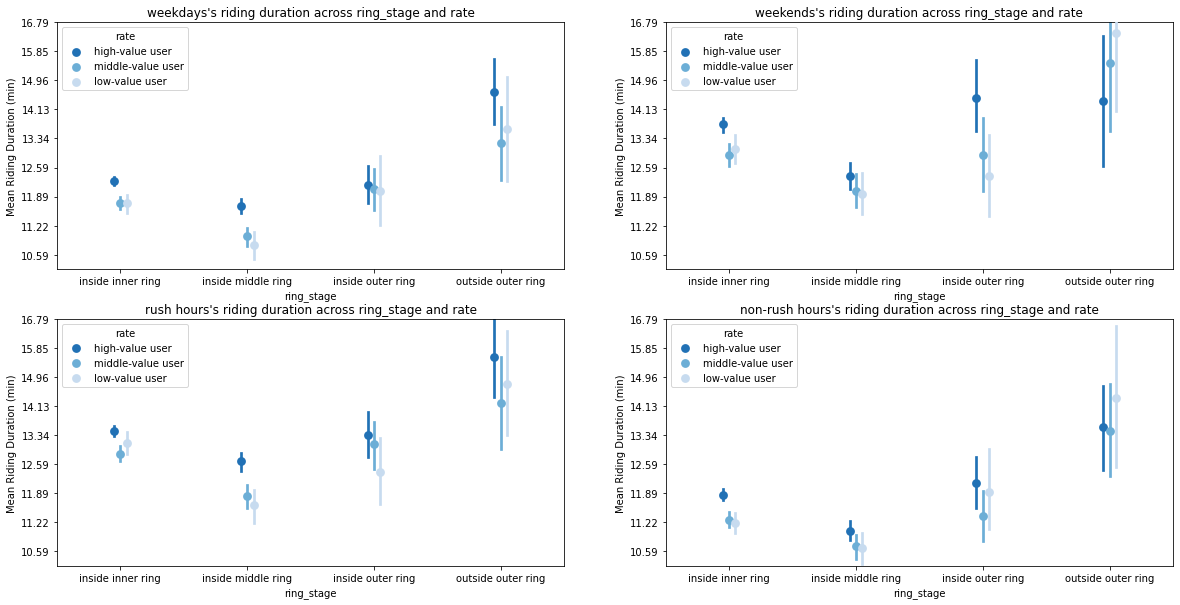

In [30]:
fig = plt.figure(figsize = [20, 10])
row_dict = {'221': {'flag': 'weekdays', 'hue': 'rate'},
            '222': {'flag': 'weekends', 'hue': 'rate'},
            '223': {'flag': 'rush hours', 'hue': 'rate'},
            '224': {'flag': 'non-rush hours', 'hue': 'rate'}}

firstplot = '221'    # 设置第一个绘图的编号，以便后续获取第一个绘图y轴的操作
for var in row_dict:
    plt.subplot(var)
    if var == '221' or var == '222':
        ax = sb.pointplot(data = df_e[df_e.daytype == row_dict[var]['flag']], x = 'ring_stage', y = 'log_ttl_min', hue = row_dict[var]['hue'],
                          palette = 'Blues_r', linestyles = '', dodge = 0.1);
    else:
        ax = sb.pointplot(data = df_e[df_e.hourtype == row_dict[var]['flag']], x = 'ring_stage', y = 'log_ttl_min', hue = row_dict[var]['hue'],
                          palette = 'Blues_r', linestyles = '', dodge = 0.1);
    ax.set_title("{}'s riding duration across ring_stage and {}".format(row_dict[var]['flag'], row_dict[var]['hue']));
    ax.set_ylabel('Mean Riding Duration (min)');
    ylocs = np.arange(1.025, 1.225, 0.025)
    ylabels = np.round(np.power(10, ylocs), 2)
    ax.set_yticks(ylocs);
    ax.set_yticklabels(ylabels);
    ax.set_yticklabels([],minor = True);    # 不显示默认的主要刻度
    if var == firstplot:
        ylim = ax.get_ylim()    # 获取第一个绘图的y轴
    else:
        plt.ylim(ylim);    # 使第二个开始的所有绘图保持和第一个绘图一致的y轴范围


- 除在外环以外的双休日和非高峰时段外，高价值用户的平均骑行时长均是最高的
- 从第一列的上下两张图中大致可以看出，工作日和高峰时段中，平均骑行时长随着用户价值变量和骑行区域变量的改变而发生的变化特征是非常相似的，这可能是因为工作日和高峰时段的用户中，上班族占了大多数，而这些上班族拥有相似的用车行为特征
- 总体上，除了内环以内的数据外，其他区域的平均骑行时长均随着骑行起点离市中心越远而变得越高

<ipython-input-31-d4f5428810fe>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(var)
<ipython-input-31-d4f5428810fe>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(var)
<ipython-input-31-d4f5428810fe>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(var)
<ipython-input-31-d4f5428810fe>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(var)
<ipython-input-31-d4f5428810fe>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprec

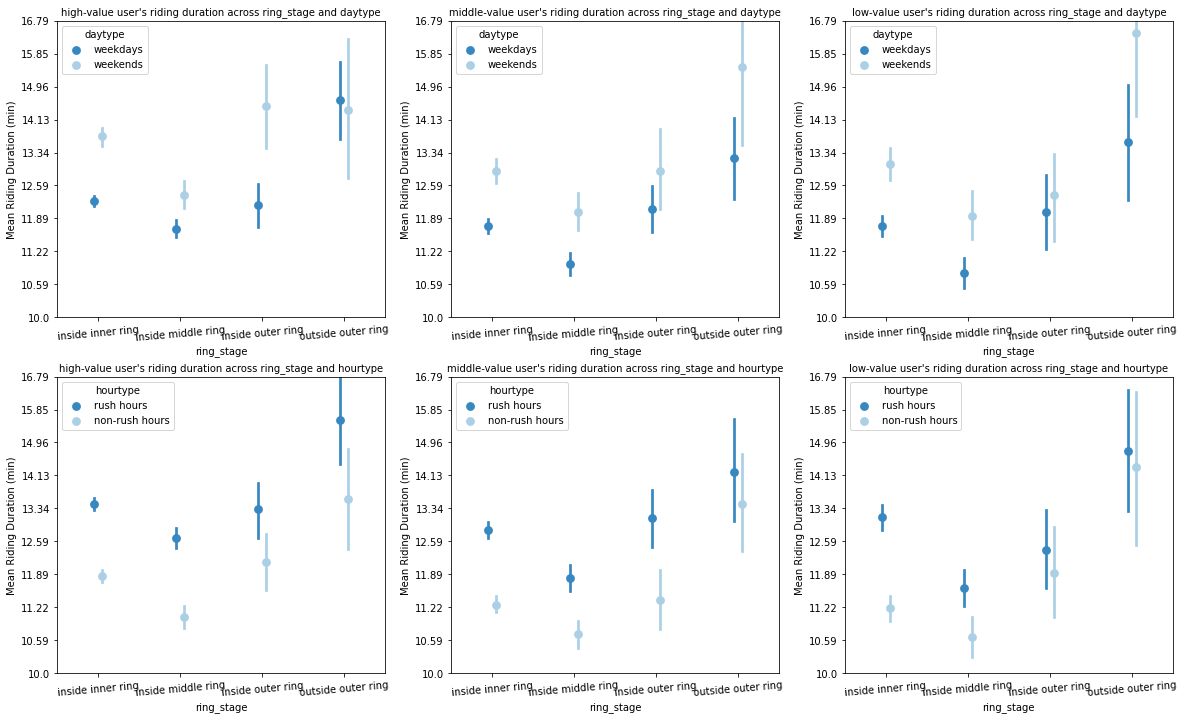

In [31]:
fig = plt.figure(figsize = [20,12])
row_dict = {'231': {'flag': 'high-value user', 'hue': 'daytype'},
            '232': {'flag': 'middle-value user', 'hue': 'daytype'},
            '233': {'flag': 'low-value user', 'hue': 'daytype'},
            '234': {'flag': 'high-value user', 'hue': 'hourtype'},
            '235': {'flag': 'middle-value user', 'hue': 'hourtype'},
            '236': {'flag': 'low-value user', 'hue': 'hourtype'}}

firstplot = '231'    # 设置第一个绘图的编号，以便后续获取第一个绘图y轴的操作
for var in row_dict:
    plt.subplot(var)
    ax = sb.pointplot(data = df_e[df_e.rate == row_dict[var]['flag']], x = 'ring_stage', y = 'log_ttl_min', hue = row_dict[var]['hue'],
           palette = 'Blues_r', linestyles = '', dodge = 0.1);
    ax.set_title("{}'s riding duration across ring_stage and {}".format(row_dict[var]['flag'], row_dict[var]['hue']), fontsize = 'medium');
    ax.set_ylabel('Mean Riding Duration (min)');
    ylocs = np.arange(1, 1.25, 0.025)
    ylabels = np.round(np.power(10, ylocs), 2)
    ax.set_yticks(ylocs);
    ax.set_yticklabels(ylabels);
    ax.set_yticklabels([],minor = True);    # 不显示默认的主要刻度
    xlabels = ax.get_xticklabels();
    ax.set_xticklabels(xlabels, rotation = 5)
    if var == firstplot:
        ylim = ax.get_ylim()    # 获取第一个绘图的y轴
    else:
        plt.ylim(ylim);    # 使第二个开始的所有绘图保持和第一个绘图一致的y轴范围


- 从第一行的图中可以观察到，除了外环以外骑行区域的数据量过少，统计数据的误差较大之外，所有双休日的平均骑行时长均高于工作日
- 第二行的图反映了所有高峰时段的平均骑行时长均高于非高峰时段
- 从第二行的图中可以观察到，除了外环以外骑行区域的数据量过少，统计数据的误差较大之外，其他区域内的平均时长总体上都随着用户价值的变低而变低

<ipython-input-32-a983e67b6193>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(var)
<ipython-input-32-a983e67b6193>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(var)
<ipython-input-32-a983e67b6193>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(var)
<ipython-input-32-a983e67b6193>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(var)
<ipython-input-32-a983e67b6193>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprec

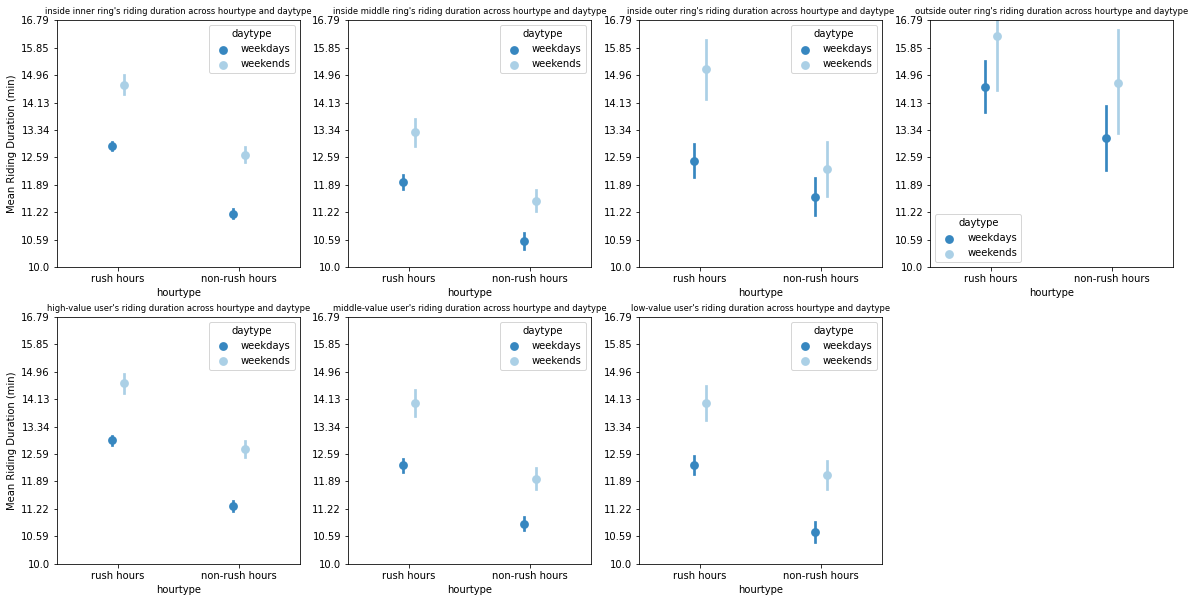

In [32]:
fig = plt.figure(figsize = [20,10])
row_dict = {'241': {'flag': 'inside inner ring', 'hue': 'daytype'},
            '242': {'flag': 'inside middle ring', 'hue': 'daytype'},
            '243': {'flag': 'inside outer ring', 'hue': 'daytype'},
            '244': {'flag': 'outside outer ring', 'hue': 'daytype'},
            '245': {'flag': 'high-value user', 'hue': 'daytype'},
            '246': {'flag': 'middle-value user', 'hue': 'daytype'},
            '247': {'flag': 'low-value user', 'hue': 'daytype'}}

firstplot = '241'    # 设置第一个绘图的编号，以便后续获取第一个绘图y轴的操作
for var in row_dict:
    plt.subplot(var)
    if var == '241' or var == '242' or var == '243' or var == '244':
        ax = sb.pointplot(data = df_e[df_e.ring_stage == row_dict[var]['flag']], x = 'hourtype', y = 'log_ttl_min',
                          hue = row_dict[var]['hue'], palette = 'Blues_r', linestyles = '', dodge = 0.1);
        ax.set_title("{}'s riding duration across hourtype and {}".format(row_dict[var]['flag'], row_dict[var]['hue']), fontsize = 'small');
    else:
        ax = sb.pointplot(data = df_e[df_e.rate == row_dict[var]['flag']], x = 'hourtype', y = 'log_ttl_min',
                          hue = row_dict[var]['hue'], palette = 'Blues_r', linestyles = '', dodge = 0.1);
        ax.set_title("{}'s riding duration across hourtype and {}".format(row_dict[var]['flag'], row_dict[var]['hue']), fontsize = 'small');
    ylocs = np.arange(1, 1.25, 0.025)
    ylabels = np.round(np.power(10, ylocs), 2)
    ax.set_yticks(ylocs);
    ax.set_yticklabels(ylabels);
    ax.set_yticklabels([],minor = True);    # 不显示默认的主要刻度
    if var == firstplot:
        ylim = ax.get_ylim()    # 获取第一个绘图的y轴
    else:
        plt.ylim(ylim);    # 使第二个开始的所有绘图保持和第一个绘图一致的y轴范围
    if var == firstplot or var == '245':    # 为每行的第一个图设置y轴标签，其他图则不显示，以防遮盖图表内容
        ax.set_ylabel('Mean Riding Duration (min)');
    else:
        ax.set_ylabel('');



- 分别限定骑行地理位置变量和用户价值变量，观察骑行时间对平均骑行时长的影响，可以发现数据点分布的相对位置高度相似，说明骑行时间对于平均骑行时长的规律明显，即在骑行地理位置或用户价值条件相同的情况下，高峰时段和双休日的平均骑行时长高于非高峰时段和工作日
- 在骑行地理位置或用户价值条件相同的情况下，工作日高峰时段的平均骑行时长近似或略高于双休日的非高峰时段
- 比较第一行和第二行的数据点分布特征，可以发现在用户价值变量视角下的数据点，随着用户价值由高到低，纵向变化幅度远低于第一行骑行位置视角下的纵向变化幅度，说明用户价值对平均骑行时长的作用较小，远小于骑行位置对其的影响

**数据探索中观察到的变量之间的相关性**

- 平均骑行时长均随着骑行起点离市中心越远而变得越高
- 骑行时间对平均骑行时长有较高影响，双休日和高峰时段的平均骑行时长均高于工作日和非高峰时段
- 由于外环线以外的数据较少，可能产生的误差较大，在其他骑行区域范围内，平均骑行时长总体上都随着用户价值的变低而变低